In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
import keras, sys, time, os, warnings
from keras.models import *
from keras.layers import *

from PIL import Image

import numpy as np
import pandas as pd 
warnings.filterwarnings("ignore")


# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "0" 
K.set_session(tf.compat.v1.Session(config=config))   


print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))


python 3.9.7 (default, Sep 16 2021, 23:53:23) 
[Clang 12.0.0 ]
keras version 2.8.0
tensorflow version 2.8.0


2022-03-09 22:34:46.416252: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-09 22:34:46.416273: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
# FTRAIN = "data/training.csv"
# FTEST  = "data/test.csv"
# FIdLookup = 'data/IdLookupTable.csv'

TRAIN_IMAGES_SOURCE = "data"
TRAIN_IMAGES_KEYPOINTS = "keypoints.csv"

TEST_IMAGES_SOURCE = "test"


In [4]:
def gaussian_k(x0,y0,sigma, width, height):
        """ Make a square gaussian kernel centered at (x0, y0) with sigma as SD.
        """
        x = np.arange(0, width, 1, float) ## (width,)
        y = np.arange(0, height, 1, float)[:, np.newaxis] ## (height,1)
        return np.exp(-((x-x0)**2 + (y-y0)**2) / (2*sigma**2))

def generate_hm(height, width ,landmarks,s=3):
        """ Generate a full Heap Map for every landmarks in an array
        Args:
            height    : The height of Heat Map (the height of target output)
            width     : The width  of Heat Map (the width of target output)
            joints    : [(x1,y1),(x2,y2)...] containing landmarks
            maxlenght : Lenght of the Bounding Box
        """
        Nlandmarks = len(landmarks)
        hm = np.zeros((height, width, Nlandmarks), dtype = np.float32)
        for i in range(Nlandmarks):
            if not np.array_equal(landmarks[i], [-1,-1]):
             
                hm[:,:,i] = gaussian_k(landmarks[i][0],
                                        landmarks[i][1],
                                        s,width, height)
            else:
                hm[:,:,i] = np.zeros((height,width))
        return hm
    
def get_y_as_heatmap(df,height,width, sigma):
    
    columns_lmxy = df.columns[1:] ## the first column contains Image
    columns_lm = [] 
    for c in columns_lmxy:
        c = c[:-1]
        if c not in columns_lm:
            columns_lm.extend([c])
    
    y_train = []
    for i in range(df.shape[0]):
        landmarks = []
        for colnm in columns_lm:
            x = df[colnm + "x"].iloc[i]
            y = df[colnm + "y"].iloc[i]
            if np.isnan(x) or np.isnan(y):
                x, y = -1, -1
            landmarks.append([x,y])
            
        y_train.append(generate_hm(height, width, landmarks, sigma))
    y_train = np.array(y_train)    
    return(y_train,df[columns_lmxy],columns_lmxy)

In [5]:
def png_to_matrix(filename, width=160, height=120, test=False):
    source = TEST_IMAGES_SOURCE if test else TRAIN_IMAGES_SOURCE

    img = Image.open(f'{source}/{filename}').resize((width, height)).convert('L')
    pixels = np.array(img)
    pixels = [item for sublist in pixels for item in sublist] ## flatten list
    return pixels


def load(test=False, width=160,height=120,sigma=5):
    """
    load test/train data
    cols : a list containing landmark label names.
           If this is specified, only the subset of the landmark labels are 
           extracted. for example, cols could be:
           
          [left_eye_center_x, left_eye_center_y]
            
    return: 
    X:  2-d numpy array (Nsample, Ncol*Nrow)
    y:  2-d numpy array (Nsample, Nlandmarks*2) 
        In total there are 15 landmarks. 
        As x and y coordinates are recorded, u.shape = (Nsample,30)
    y0: panda dataframe containins the landmarks
       
    """
    from sklearn.utils import shuffle

    if test:
        filenames = []
        directory = TEST_IMAGES_SOURCE
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.endswith(".png"):
                filenames.append(filename)

        df = pd.DataFrame(data={'Image': filenames})
    else:
        df = pd.read_csv(os.path.expanduser(TRAIN_IMAGES_KEYPOINTS))
        for column in df.columns[1:]:
          df[column] = df[column].apply(lambda val: val//4)

    df['Image'] = df['Image'].apply(lambda im: png_to_matrix(im, width, height, test))

    myprint = df.count()
    myprint = myprint.reset_index()
    print(myprint)

    X = np.vstack(df['Image'].values) / 255.  # changes valeus between 0 and 1
    X = X.astype(np.float32)

    if not test:  # labels only exists for the training data
        y, y0, nm_landmark = get_y_as_heatmap(df,height,width, sigma)
        X, y, y0 = shuffle(X, y, y0, random_state=42)  # shuffle data   
        y = y.astype(np.float32)
    else:
        y, y0, nm_landmark = None, None, None    
    return X, y, y0, nm_landmark

def load2d(test=False,width=160,height=120,sigma=5):

    re   = load(test,width,height,sigma)
    X    = re[0].reshape(-1,height,width,1)
    y, y0, nm_landmarks = re[1:]
    
    return X, y, y0, nm_landmarks






In [6]:
sigma = 5

X_train, y_train, y_train0, nm_landmarks = load2d(test=False,sigma=sigma)
X_test,  y_test, _, _ = load2d(test=True,sigma=sigma)
print(X_train.shape, y_train.shape, y_train0.shape)
print(X_test.shape, y_test)


    index    0
0   Image  317
1      1x  317
2      1y  317
3      2x  317
4      2y  317
5      3x  317
6      3y  317
7      4x  317
8      4y  317
9      5x  317
10     5y  317
11     6x  317
12     6y  317
13     7x  317
14     7y  317
15     8x  317
16     8y  317
17     9x  317
18     9y  317
   index   0
0  Image  24
(317, 120, 160, 1) (317, 120, 160, 9) (317, 18)
(24, 120, 160, 1) None


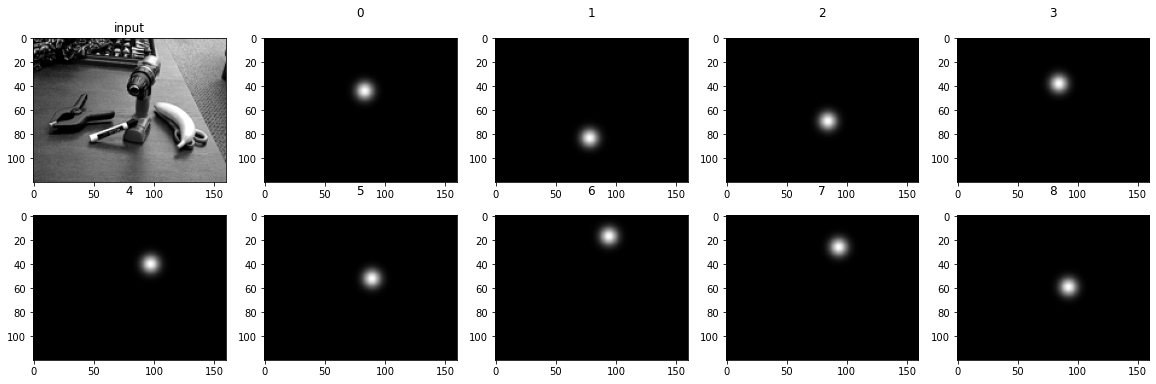

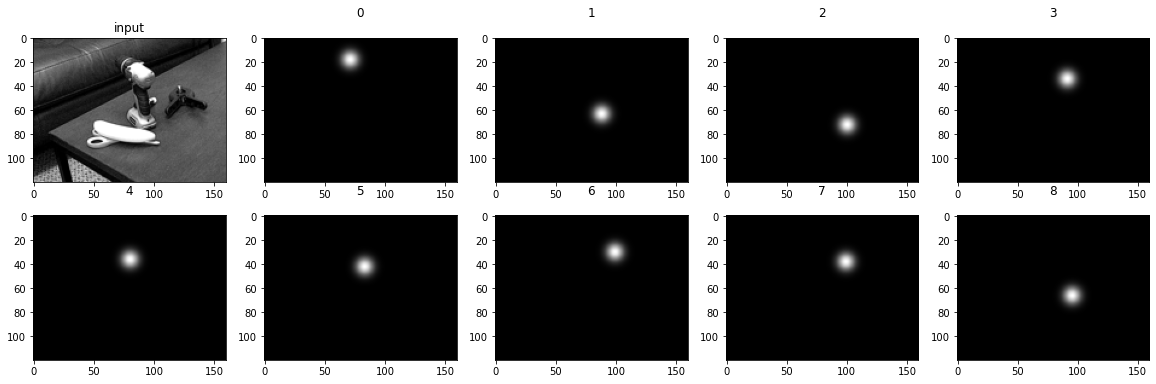

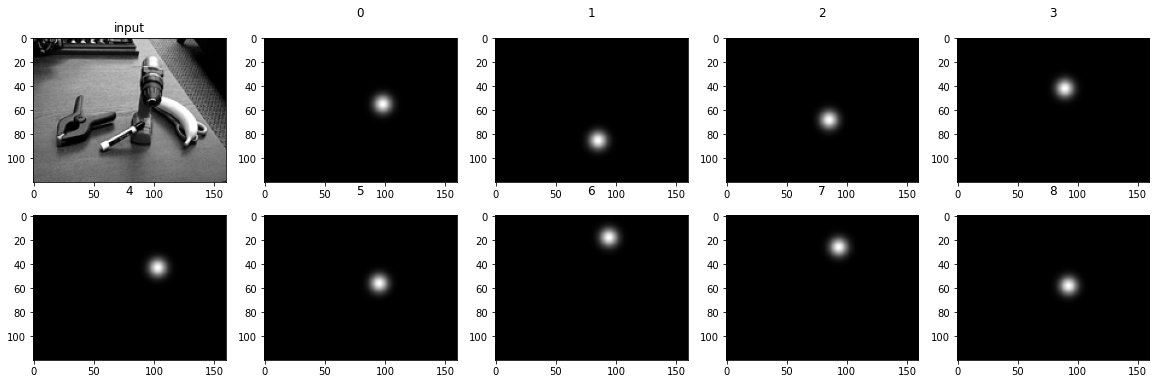

In [7]:
Nplot = y_train.shape[3]+1

for i in range(3):
    fig = plt.figure(figsize=(20,6))
    ax = fig.add_subplot(2,Nplot//2,1)
    ax.imshow(X_train[i,:,:,0],cmap="gray")
    ax.set_title("input")
    for j, lab in enumerate(nm_landmarks[::2]):
        ax = fig.add_subplot(2,Nplot/2,j+2)
        ax.imshow(y_train[i,:,:,j],cmap="gray")
        ax.set_title(str(j) +"\n" + lab[:-2] )
    plt.show()


In [8]:
landmark_order = {"orig" : [0,1,2,3,4,5,6,7,8],
                  "new"  : [0,1,2,3,4,5,6,7,8]}

In [9]:
from skimage import transform
from skimage.transform import SimilarityTransform, AffineTransform
import random 


def transform_img(data,
                  loc_w_batch=2,
                  max_rotation=30,
                  max_shift=25,
                  max_shear=0,
                  max_scale=0.1,mode="edge"):
    '''
    data : list of numpy arrays containing a single image
    e.g., data = [X, y, w] or data = [X, y]
    X.shape = (height, width, NfeatX)
    y.shape = (height, width, Nfeaty)
    w.shape = (height, width, Nfeatw)
    NfeatX, Nfeaty and Nfeatw can be different
    
    affine transformation for a single image
    
    loc_w_batch : the location of the weights in the fourth dimention
    [,,,loc_w_batch]
    '''
    scale = (np.random.uniform(1-max_scale, 1 + max_scale),
             np.random.uniform(1-max_scale, 1 + max_scale))
    rotation_tmp = np.random.uniform(-1*max_rotation, max_rotation)
    translation = (np.random.uniform(-1*max_shift, max_shift),
                   np.random.uniform(-1*max_shift, max_shift))
    shear = np.random.uniform(-1*max_shear, max_shear)
    tform = AffineTransform(
            scale=scale,#,
            ## Convert angles from degrees to radians.
            rotation=np.deg2rad(rotation_tmp),
            translation=translation,
            shear=np.deg2rad(shear)
        )
    
    for idata, d in enumerate(data):
        if idata != loc_w_batch:
            ## We do NOT need to do affine transformation for weights
            ## as weights are fixed for each (image,landmark) combination
            data[idata] = transform.warp(d, tform,mode=mode)
    return data
def transform_imgs(data, lm, 
                   loc_y_batch = 1, 
                   loc_w_batch = 2):
    '''
    data : list of numpy arrays containing a single image
    e.g., data = [X, y, w] or data = [X, y]
    X.shape = (height, width, NfeatX)
    y.shape = (height, width, Nfeaty)
    w.shape = (height, width, Nfeatw)
    NfeatX, Nfeaty and Nfeatw can be different
    
    affine transformation for a single image
    '''
    Nrow  = data[0].shape[0]
    Ndata = len(data) 
    data_transform = [[] for i in range(Ndata)]
    for irow in range(Nrow):
        data_row = []
        for idata in range(Ndata):
            data_row.append(data[idata][irow])
        ## affine transformation
        data_row_transform = transform_img(data_row,
                                          loc_w_batch)
        ## horizontal flip
        data_row_transform = horizontal_flip(data_row_transform,
                                             lm,
                                             loc_y_batch,
                                             loc_w_batch)
        
        for idata in range(Ndata):
            data_transform[idata].append(data_row_transform[idata])
    
    for idata in range(Ndata):
        data_transform[idata] = np.array(data_transform[idata])
    
    
    return(data_transform)

def horizontal_flip(data,lm,loc_y_batch=1,loc_w_batch=2):  
    '''
    flip the image with 50% chance
    
    lm is a dictionary containing "orig" and "new" key
    This must indicate the potitions of heatmaps that need to be flipped  
    landmark_order = {"orig" : [0,1,2,3,4,5,6,7,8,9,11,12],
                      "new"  : [1,0,4,5,2,3,8,9,6,7,12,11]}
                      
    data = [X, y, w]
    w is optional and if it is in the code, the position needs to be specified
    with loc_w_batch
    
    X.shape (height,width,n_channel)
    y.shape (height,width,n_landmarks)
    w.shape (height,width,n_landmarks)
    '''
    lo, ln = np.array(lm["orig"]), np.array(lm["new"])

    assert len(lo) == len(ln)
    if np.random.choice([0,1]) == 1:
        return(data)
    
    for i, d in enumerate(data):
        d = d[:, ::-1,:] 
        data[i] = d


    data[loc_y_batch] = swap_index_for_horizontal_flip(
        data[loc_y_batch], lo, ln)

    # when horizontal flip happens to image, we need to heatmap (y) and weights y and w
    # do this if loc_w_batch is within data length
    if loc_w_batch < len(data):
        data[loc_w_batch] = swap_index_for_horizontal_flip(
            data[loc_w_batch], lo, ln)
    return(data)

def swap_index_for_horizontal_flip(y_batch, lo, ln):
    '''
    lm = {"orig" : [0,1,2,3,4,5,6,7,8,9,11,12],
          "new"  : [1,0,4,5,2,3,8,9,6,7,12,11]}
    lo, ln = np.array(lm["orig"]), np.array(lm["new"])                  
    '''
    y_orig = y_batch[:,:, lo]
    y_batch[:,:, lo] = y_batch[:,:, ln] 
    y_batch[:,:, ln] = y_orig
    return(y_batch)

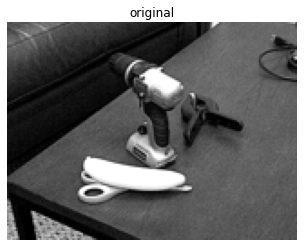

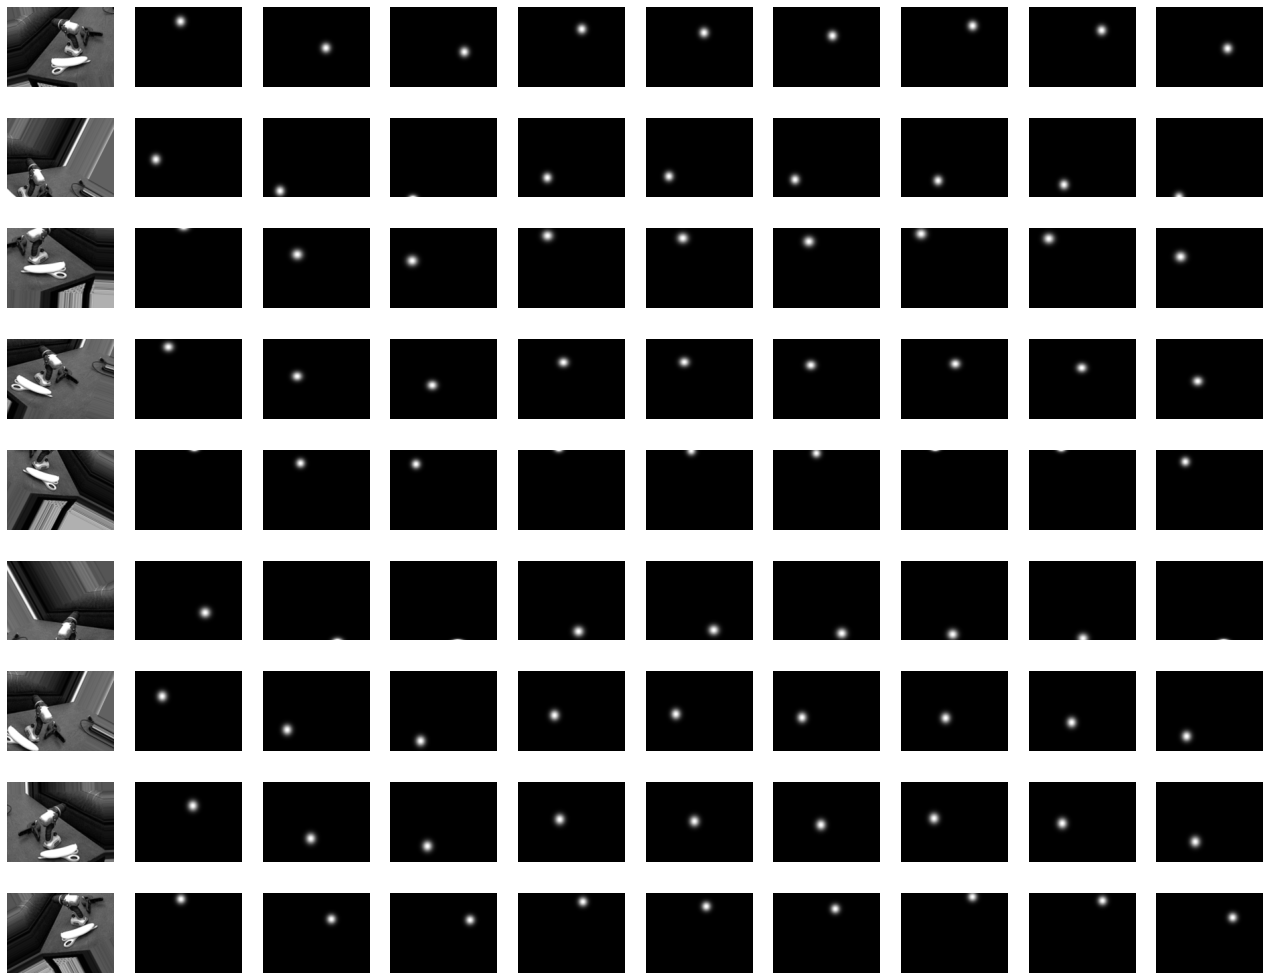

In [10]:
## example image to  visualize the data augmentation
iexample = 139
## Show the first 13 heatmaps
Nhm = 9

plt.imshow(X_train[iexample,:,:,0],cmap="gray")
plt.title("original")
plt.axis("off")
plt.show()
Nplot = 9
fig = plt.figure(figsize=[Nhm*2.5,2*Nplot])


landmark_order = {"orig" : [0,1,2,3,4,5,6,7,8],
                  "new"  : [0,1,2,3,4,5,6,7,8]}


count = 1
for _ in range(Nplot):
    x_batch, y_batch = transform_imgs([X_train[[iexample]],
                                       y_train[[iexample]]],
                                     landmark_order)
    ax = fig.add_subplot(Nplot,Nhm+1,count)
    ax.imshow(x_batch[0,:,:,0],cmap="gray")
    ax.axis("off")
    count += 1 
    
    for ifeat in range(Nhm):
        ax = fig.add_subplot(Nplot,Nhm + 1,count)
        ax.imshow(y_batch[0,:,:,ifeat],cmap="gray")
        ax.axis("off")
        if count < Nhm + 2:
            ax.set_title(nm_landmarks[ifeat*2][:-2])
        count += 1
plt.show()

In [11]:
prop_train = 0.9
Ntrain = int(X_train.shape[0]*prop_train)
X_tra, y_tra, X_val,y_val = X_train[:Ntrain],y_train[:Ntrain],X_train[Ntrain:],y_train[Ntrain:]
del X_train, y_train

Model Conv

In [12]:
input_height, input_width = 120, 160
## output shape is the same as input
output_height, output_width = input_height, input_width 
n = 32*5
nClasses = 9
nfmp_block1 = 64
nfmp_block2 = 128

IMAGE_ORDERING =  "channels_last" 
img_input = Input(shape=(input_height,input_width, 1)) 

# Encoder Block 1
x = Conv2D(nfmp_block1, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING )(img_input)
x = Conv2D(nfmp_block1, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING )(x)
block1 = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(x)
    
# Encoder Block 2
x = Conv2D(nfmp_block2, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING )(block1)
x = Conv2D(nfmp_block2, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING )(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(x)
    
## bottoleneck    
o = (Conv2D(n, (input_height//4, input_width//4), 
            activation='relu' , padding='same', name="bottleneck_1", data_format=IMAGE_ORDERING))(x)
o = (Conv2D(n , ( 1 , 1 ) , activation='relu' , padding='same', name="bottleneck_2", data_format=IMAGE_ORDERING))(o)


## upsamping to bring the feature map size to be the same as the one from block1
## o_block1 = Conv2DTranspose(nfmp_block1, kernel_size=(2,2),  strides=(2,2), use_bias=False, name='upsample_1', data_format=IMAGE_ORDERING )(o)
## o = Add()([o_block1,block1])
## output   = Conv2DTranspose(nClasses,    kernel_size=(2,2),  strides=(2,2), use_bias=False, name='upsample_2', data_format=IMAGE_ORDERING )(o)

## Decoder Block
## upsampling to bring the feature map size to be the same as the input image i.e., heatmap size
output   = Conv2DTranspose(nClasses,    kernel_size=(4,4),  strides=(4,4), use_bias=False, name='upsample_2', data_format=IMAGE_ORDERING )(o)

## Reshaping is necessary to use sample_weight_mode="temporal" which assumes 3 dimensional output shape
## See below for the discussion of weights
output = Reshape((output_width*input_height*nClasses,1))(output)
model = Model(img_input, output)
model.summary()

model.compile(loss='mse',optimizer="rmsprop",sample_weight_mode="temporal")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 160, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 160, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 30, 40, 128)       0     

2022-03-09 22:34:53.456292: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-09 22:34:53.456314: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
def find_weight(y_tra):
    '''
    :::input:::
    
    y_tra : np.array of shape (N_image, height, width, N_landmark)
    
    :::output::: 
    
    weights : 
        np.array of shape (N_image, height, width, N_landmark)
        weights[i_image, :, :, i_landmark] = 1 
                        if the (x,y) coordinate of the landmark for this image is recorded.
        else  weights[i_image, :, :, i_landmark] = 0

    '''
    weight = np.zeros_like(y_tra)
    count0, count1 = 0, 0
    for irow in range(y_tra.shape[0]):
        for ifeat in range(y_tra.shape[-1]):
            if np.all(y_tra[irow,:,:,ifeat] == 0):
                value = 0
                count0 += 1
            else:
                value = 1
                count1 += 1
            weight[irow,:,:,ifeat] = value
    print("N landmarks={:5.0f}, N missing landmarks={:5.0f}, weight.shape={}".format(
        count0,count1,weight.shape))
    return(weight)


def flatten_except_1dim(weight,ndim=2):
    '''
    change the dimension from:
    (a,b,c,d,..) to (a, b*c*d*..) if ndim = 2
    (a,b,c,d,..) to (a, b*c*d*..,1) if ndim = 3
    '''
    n = weight.shape[0]
    if ndim == 2:
        shape = (n,-1)
    elif ndim == 3:
        shape = (n,-1,1)

    elif ndim == 4:
        shape = (n,-1,1)
    else:
        print("Not implemented!")
    weight = weight.reshape(*shape)
    return(weight)


In [14]:
w_tra = find_weight(y_tra)

weight_val = find_weight(y_val)
weight_val = flatten_except_1dim(weight_val)
y_val_fla  = flatten_except_1dim(y_val,ndim=3) 

## print("weight_tra.shape={}".format(weight_tra.shape))
print("weight_val.shape={}".format(weight_val.shape))
print("y_val_fla.shape={}".format(y_val_fla.shape))
print(model.output)


N landmarks=    0, N missing landmarks= 2565, weight.shape=(285, 120, 160, 9)
N landmarks=    0, N missing landmarks=  288, weight.shape=(32, 120, 160, 9)
weight_val.shape=(32, 172800)
y_val_fla.shape=(32, 172800, 1)
KerasTensor(type_spec=TensorSpec(shape=(None, 172800, 1), dtype=tf.float32, name=None), name='reshape/Reshape:0', description="created by layer 'reshape'")


In [15]:
# #!/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """Stacked Hourglass model blocks definition in Keras."""
# from tensorflow.keras.layers import Conv2D, SeparableConv2D, BatchNormalization, MaxPool2D, Add, UpSampling2D
# import tensorflow.keras.backend as K


# def bottleneck_block(x, num_out_channels, block_name):
#     """
#     normal hourglass bottleneck block,
#     using standard conv
#     """
#     # skip layer
#     if K.int_shape(x)[-1] == num_out_channels:
#         _skip = x
#     else:
#         _skip = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
#                        name=block_name + '_skip')(x)

#     # residual: 3 conv blocks,  [num_out_channels/2  -> num_out_channels/2 -> num_out_channels]
#     _x = Conv2D(num_out_channels//2, kernel_size=(1, 1), activation='relu', padding='same',
#                 name=block_name + '_conv_1x1_1')(x)
#     _x = BatchNormalization()(_x)
#     _x = Conv2D(num_out_channels//2, kernel_size=(3, 3), activation='relu', padding='same',
#                 name=block_name + '_conv_3x3_2')(_x)
#     _x = BatchNormalization()(_x)
#     _x = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
#                 name=block_name + '_conv_1x1_3')(_x)
#     _x = BatchNormalization()(_x)

#     # merge residual and skip branch
#     _x = Add(name=block_name + '_add')([_skip, _x])

#     return _x


# def bottleneck_mobile(x, num_out_channels, block_name):
#     """
#     lightweight hourglass bottleneck block,
#     using separable conv
#     """
#     # skip layer
#     if K.int_shape(x)[-1] == num_out_channels:
#         _skip = x
#     else:
#         _skip = SeparableConv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
#                                 name=block_name + '_skip')(x)

#     # residual: 3 conv blocks,  [num_out_channels/2  -> num_out_channels/2 -> num_out_channels]
#     _x = SeparableConv2D(num_out_channels // 2, kernel_size=(1, 1), activation='relu', padding='same',
#                          name=block_name + '_conv_1x1_1')(x)
#     _x = BatchNormalization()(_x)
#     _x = SeparableConv2D(num_out_channels // 2, kernel_size=(3, 3), activation='relu', padding='same',
#                          name=block_name + '_conv_3x3_2')(_x)
#     _x = BatchNormalization()(_x)
#     _x = SeparableConv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
#                          name=block_name + '_conv_1x1_3')(_x)
#     _x = BatchNormalization()(_x)

#     # merge residual and skip branch
#     _x = Add(name=block_name + '_add')([_skip, _x])

#     return _x


# def create_front_module(input_tensor, num_channels, bottleneck):
#     """
#     front module block, input to 1/4 resolution:
#       input_tensor: 256 x 256 x 3
#       front_residual_3 output: 64 x 64 x num_channels

#     using following blocks:
#       * 1 7x7 conv + maxpooling
#       * 3 residual block
#     """
#     _x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu', name='front_conv_1x1_1')(input_tensor)
#     _x = BatchNormalization()(_x)

#     _x = bottleneck(_x, num_channels//2, 'front_residual_1')
#     _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(_x)

#     _x = bottleneck(_x, num_channels//2, 'front_residual_2')
#     _x = bottleneck(_x, num_channels, 'front_residual_3')

#     return _x


# def hourglass_module(x, num_classes, num_channels, bottleneck, hg_id):
#     """
#     single hourglass module block
#       1. downsample feature map to 1/8 size
#       2. upsample back to origin
#       3. create 2 heads for next stage and loss/prediction
#     """
#     # create downsample features: f1, f2, f4 and f8
#     downsample_features = create_downsample_blocks(x, bottleneck, hg_id, num_channels)

#     # create upsample features, and connect with downsample features
#     upsample_feature = create_upsample_blocks(downsample_features, bottleneck, hg_id, num_channels)

#     # add 1x1 conv with two heads, head_next_stage is for next stage hourglass,
#     # head_predict is for intermediate supervision (loss) or final prediction
#     head_next_stage, head_predict = create_heads(x, upsample_feature, num_classes, hg_id, num_channels)

#     return head_next_stage, head_predict


# def create_downsample_blocks(x, bottleneck, hg_id, num_channels):
#     """
#     create downsample blocks and 4 different scale features for hourglass module
#       input image: 256 x 256 x 3
#       x: 64 x 64 x num_channels

#       downsample_f1 feature: 64 x 64 x num_channels
#       downsample_f2 feature: 32 x 32 x num_channels
#       downsample_f4 feature: 16 x 16 x num_channels
#       downsample_f8 feature: 8 x 8 x num_channels
#     """
#     hg_name = 'hg' + str(hg_id)

#     downsample_f1 = bottleneck(x, num_channels, hg_name + '_downsample_1')
#     _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(downsample_f1)

#     downsample_f2 = bottleneck(_x, num_channels, hg_name + '_downsample_2')
#     _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(downsample_f2)

#     downsample_f4 = bottleneck(_x, num_channels, hg_name + '_downsample_4')
#     _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(downsample_f4)

#     downsample_f8 = bottleneck(_x, num_channels, hg_name + '_downsample_8')

#     return (downsample_f1, downsample_f2, downsample_f4, downsample_f8)


# def connect_downsample_upsample(downsample_feature, upsample_feature, bottleneck, num_channels, name):
#     """
#     merge downsample feature and low scale upsample feature to
#     create high scale upsample feature:

#     1. apply 1 bottleneck block for downsample feature
#     2. upsampling low scale upsample feature
#     3. merge downsample && upsample features
#     4. apply 1 bottleneck block for merged feature
#     """
#     downsample_x = bottleneck(downsample_feature, num_channels, name + '_short')

#     upsample_x = UpSampling2D()(upsample_feature)

#     # merge downsample && upsample features
#     x = Add()([downsample_x, upsample_x])
#     # apply bottleneck block to merged feature
#     out = bottleneck(x, num_channels, name + '_merged')

#     return out


# def bottom_block(downsample_f8, bottleneck, hg_id, num_channels):
#     """
#     blocks in lowest resolution(8x8 for 256x256 input) to
#     create upsample_f8 from downsample_f8:
#       1. 1 bottleneck block for shortcut
#       2. 3 bottleneck blocks for main branch
#       3. add shortcut and main
#     """
#     hg_name = 'hg' + str(hg_id)

#     downsample_f8_short = bottleneck(downsample_f8, num_channels, hg_name+"_downsample_f8_short")

#     _x = bottleneck(downsample_f8, num_channels, hg_name+"_downsample_f8_1")
#     _x = bottleneck(_x, num_channels, hg_name+"_downsample_f8_2")
#     _x = bottleneck(_x, num_channels, hg_name+"_downsample_f8_3")

#     upsample_f8 = Add()([_x, downsample_f8_short])

#     return upsample_f8


# def create_upsample_blocks(downsample_features, bottleneck, hg_id, num_channels):
#     """
#     do upsample and merge 4 different scale downsample features to get final upsample feature map

#       downsample_f1 feature: 64 x 64 x num_channels
#       downsample_f2 feature: 32 x 32 x num_channels
#       downsample_f4 feature: 16 x 16 x num_channels
#       downsample_f8 feature: 8 x 8 x num_channels

#       upsample_f8 feature: 8 x 8 x num_channels
#       upsample_f4 feature: 16 x 16 x num_channels
#       upsample_f2 feature: 32 x 32 x num_channels
#       upsample_f1 feature: 64 x 64 x num_channels
#     """
#     hg_name = 'hg' + str(hg_id)

#     downsample_f1, downsample_f2, downsample_f4, downsample_f8 = downsample_features

#     upsample_f8 = bottom_block(downsample_f8, bottleneck, hg_id, num_channels)
#     upsample_f4 = connect_downsample_upsample(downsample_f4, upsample_f8, bottleneck, num_channels, hg_name+'_upsample_f4')
#     upsample_f2 = connect_downsample_upsample(downsample_f2, upsample_f4, bottleneck, num_channels, hg_name+'_upsample_f2')
#     upsample_f1 = connect_downsample_upsample(downsample_f1, upsample_f2, bottleneck, num_channels, hg_name+'_upsample_f1')

#     return upsample_f1


# def create_heads(x, upsample_feature, num_classes, hg_id, num_channels):
#     """
#     create two output heads for hourglass module
#       * one head for next stage: head_next_stage
#       * one head for intermediate supervision (loss) or final prediction: head_predict
#     """
#     hg_name = 'hg' + str(hg_id)

#     head = Conv2D(num_channels, kernel_size=(1, 1), activation='relu', padding='same', name=hg_name+'_conv_1x1_1')(upsample_feature)
#     head = BatchNormalization()(head)

#     # for head as intermediate supervision, use 'linear' as activation.
#     head_predict = Conv2D(num_classes, kernel_size=(1, 1), activation='linear', padding='same',
#                         name=hg_name+'_conv_1x1_predict')(head)

#     # use linear activation
#     head = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
#                   name=hg_name+'_conv_1x1_2')(head)
#     head_m = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
#                     name=hg_name+'_conv_1x1_3')(head_predict)

#     # merge heads for next stage
#     head_next_stage = Add()([head, head_m, x])

#     return head_next_stage, head_predict



In [16]:
# def get_hourglass_model(num_classes, num_stacks, num_channels, model_input_shape=None, mobile=False):
#     # whether to use depthwise conv use choose model type
#     if mobile:
#         bottleneck = bottleneck_mobile
#     else:
#         bottleneck = bottleneck_block

#     # prepare input tensor
#     if model_input_shape:
#         input_tensor = Input(shape=(model_input_shape[0], model_input_shape[1], 3), name='image_input')
#     else:
#         input_tensor = Input(shape=(None, None, 3), name='image_input')

#     # front module, input to 1/4 resolution
#     front_features = create_front_module(input_tensor, num_channels, bottleneck)

#     # form up hourglass stacks and get head of
#     # each module for intermediate supervision
#     head_next_stage = front_features
#     outputs = []
#     for i in range(num_stacks):
#         head_next_stage, head_to_loss = hourglass_module(head_next_stage, num_classes, num_channels, bottleneck, i)
#         outputs.append(head_to_loss)

#     # create multi output model for intermediate supervision training process
#     model = Model(inputs=input_tensor, outputs=outputs)

#     return model


In [17]:
# from keras.optimizers import rmsprop_v2
# from keras.losses import mean_squared_error

# model = get_hourglass_model(16, 2, 64, (128, 128))
# model.compile(optimizer=rmsprop_v2.RMSProp(learning_rate=5e-4), loss=mean_squared_error, metrics=["accuracy"])

In [18]:
nb_epochs = 20
batch_size = 32
const = 10 
history = {"loss":[],"val_loss":[]}
for iepoch in range(nb_epochs):
    start = time.time()
    
    
    x_batch, y_batch, w_batch = transform_imgs([X_tra,y_tra, w_tra],landmark_order)
    # If you want no data augementation, comment out the line above and uncomment the comment below:
    # x_batch, y_batch, w_batch = X_tra,y_tra, w_tra 
    w_batch_fla = flatten_except_1dim(w_batch,ndim=2)
    y_batch_fla = flatten_except_1dim(y_batch,ndim=3)
    
    hist = model.fit(x_batch,
                     y_batch_fla*const,
                     sample_weight = w_batch_fla,
                     validation_data=(X_val,y_val_fla*const,weight_val),
                     batch_size=batch_size,
                     epochs=1,
                     verbose=0)
    history["loss"].append(hist.history["loss"][0])
    history["val_loss"].append(hist.history["val_loss"][0])
    end = time.time()
    print("Epoch {:03}: loss {:6.4f} val_loss {:6.4f} {:4.1f}sec".format(
        iepoch+1,history["loss"][-1],history["val_loss"][-1],end-start))


2022-03-09 22:35:42.275147: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-09 22:35:42.622509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-09 22:36:28.067303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 001: loss 0.4422 val_loss 0.3927 49.5sec
Epoch 002: loss 0.3520 val_loss 0.3887 47.4sec
Epoch 003: loss 0.3287 val_loss 0.3981 47.9sec
Epoch 004: loss 0.3504 val_loss 0.3858 50.6sec
Epoch 005: loss 0.3400 val_loss 0.3988 348.4sec
Epoch 006: loss 0.3552 val_loss 0.3795 55.1sec
Epoch 007: loss 0.3366 val_loss 0.3868 54.7sec
Epoch 008: loss 0.3428 val_loss 0.3666 58.4sec


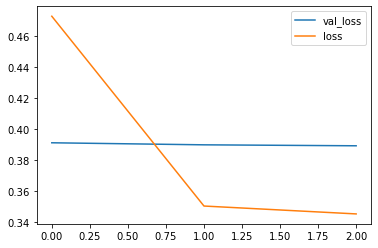

2022-03-09 22:13:14.959305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


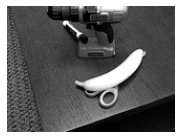

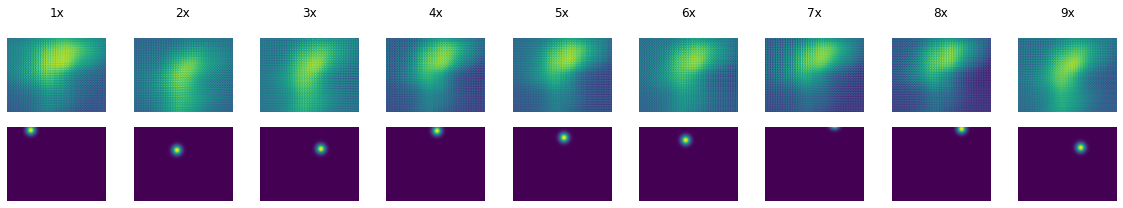

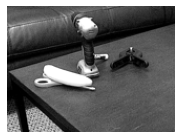

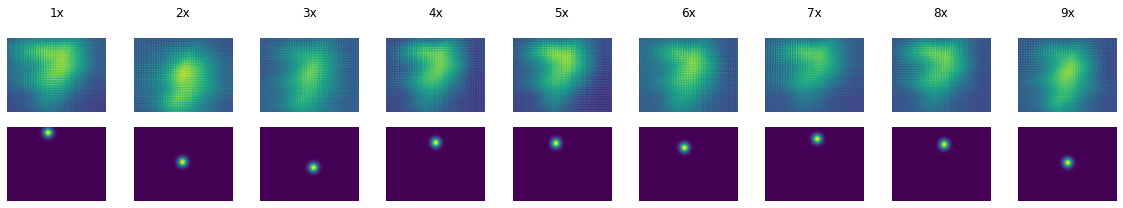

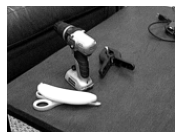

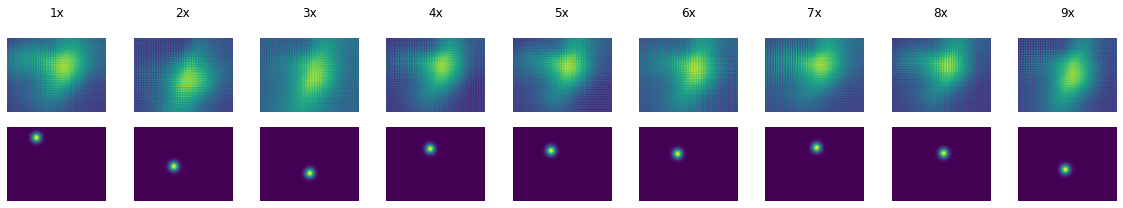

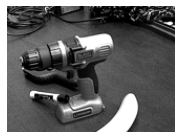

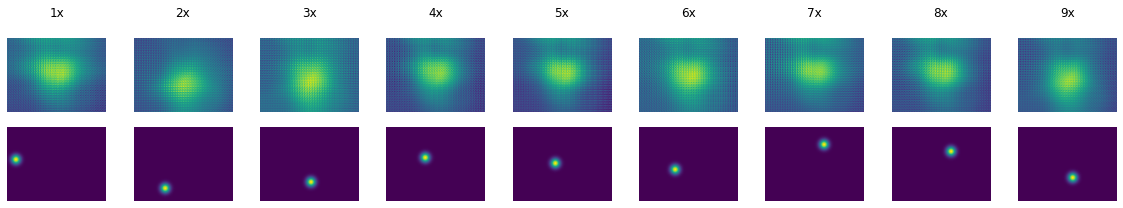

In [153]:
for label in ["val_loss","loss"]:
    plt.plot(history[label],label=label)
plt.legend()
plt.show()

y_pred = model.predict(X_tra)
y_pred = y_pred.reshape(-1,output_height,output_width,nClasses)

Nlandmark = y_pred.shape[-1]
for i in range(96,100):
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(X_tra[i,:,:,0],cmap="gray")
    ax.axis("off")
    
    fig = plt.figure(figsize=(20,3))
    count = 1
    for j, lab in enumerate(nm_landmarks[::2]):
        ax = fig.add_subplot(2,Nlandmark,count)
        ax.set_title(lab[:10] + "\n" + lab[10:-2])
        ax.axis("off")
        count += 1
        ax.imshow(y_pred[i,:,:,j])
        if j == 0:
            ax.set_ylabel("prediction")
            
    for j, lab in enumerate(nm_landmarks[::2]):
        ax = fig.add_subplot(2,Nlandmark,count)
        count += 1
        ax.imshow(y_tra[i,:,:,j])   
        ax.axis("off")
        if j == 0:
            ax.set_ylabel("true")
    plt.show()

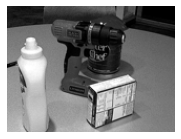

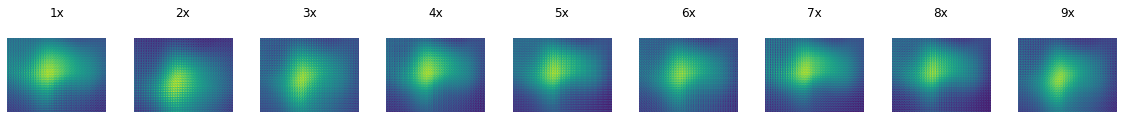

In [154]:
y_pred_test = model.predict(X_test)  ## estimated heatmap
y_pred_test = y_pred_test.reshape(-1,output_height,output_width,nClasses)

Nlandmark = y_pred_test.shape[-1]
for i in range(10,11):
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(X_test[i,:,:,0],cmap="gray")
    ax.axis("off")
    
    fig = plt.figure(figsize=(20,3))
    count = 1
    for j, lab in enumerate(nm_landmarks[::2]):
        ax = fig.add_subplot(2,Nlandmark,count)
        ax.set_title(lab[:10] + "\n" + lab[10:-2])
        ax.axis("off")
        count += 1
        ax.imshow(y_pred_test[i,:,:,j])
        if j == 0:
            ax.set_ylabel("prediction")
            
    # for j, lab in enumerate(nm_landmarks[::2]):
    #     ax = fig.add_subplot(2,Nlandmark,count)
    #     count += 1
    #     ax.imshow(y_tra[i,:,:,j])   
    #     ax.axis("off")
    #     if j == 0:
    #         ax.set_ylabel("true")
    plt.show()